![t1](t1.jpg)

### Group Member:
* Linda Xu;
* Nian Liu;
* Xinyue Wang

### Data Description
train.csv
* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees. 
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online- playlist, song .. etc. 
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise 

songs.csv
The songs. Note that data is in unicode. 
* song_id
* song_length: in ms
* genre_ids: genre category. Some songs have multiple genres and they are separated by |
* artist_name
* composer
* lyricist
* language


members.csv： user information.

* msno
* city
* bd: age. Note: this column has outlier values, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d

In [ ]:
import numpy as np
from scipy import sparse
import pandas as pd
import lightgbm as lgb 

import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools
import lightgbm as lgb 
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import display
import datetime

In [2]:
train_data = pd.read_csv('input/train.csv')

test_data = pd.read_csv('input/test.csv')
members = pd.read_csv('input/members.csv')
song_extra_info = pd.read_csv('input/song_extra_info.csv')
songs = pd.read_csv('input/songs.csv')

train_size = train_data.shape[0]

# Part 1 :Data preprocessing

### Basic preprocessing
#### Take a look at train and test data

In [3]:
display(train_data.head())
display(test_data.head())

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


#### Merge training and testing data
This is to simplify the efforts for feature engineering otherwise we'll have to perform the same transfromations for both train and test.

In [4]:
full_data = pd.concat([train_data,test_data])
display(full_data.head())

,id,msno,song_id,source_screen_name,source_system_tab,source_type,target
0,NaN,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,Explore,explore,online-playlist,1.0
1,NaN,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,Local playlist more,my library,local-playlist,1.0
2,NaN,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,Local playlist more,my library,local-playlist,1.0
3,NaN,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,Local playlist more,my library,local-playlist,1.0
4,NaN,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,Explore,explore,online-playlist,1.0


## Song features

In [5]:
display(songs.head(10))

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,NaN,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


Before looking at the exact value in each column, we need to take care tht missing value in each column


In [6]:
print "Any row has nan value in %s column : %r"%('song_id',songs['song_id'].isnull().any())
print "Any row has nan value in %s column : %r"%('song_length',songs['song_length'].isnull().any())
print "Any row has nan value in %s column : %r"%('genre_ids',songs['genre_ids'].isnull().any())
print "Any row has nan value in %s column : %r"%('artist_name',songs['artist_name'].isnull().any())
print "Any row has nan value in %s column : %r"%('composer',songs['composer'].isnull().any())
print "Any row has nan value in %s column : %r"%('lyricist',songs['lyricist'].isnull().any())
print "Any row has nan value in %s column : %r"%('language',songs['language'].isnull().any())


Any row has nan value in song_id column : False
Any row has nan value in song_length column : False
Any row has nan value in genre_ids column : True
Any row has nan value in artist_name column : False
Any row has nan value in composer column : True
Any row has nan value in lyricist column : True
Any row has nan value in language column : True


1st. we need to take care of missing value in 4 features: "genre_ids", "composer", "lyricist", "language"

In [7]:
songs['genre_ids'].fillna('000',inplace=True)
songs['composer'].fillna('no_c',inplace=True)
songs['lyricist'].fillna('no_l',inplace=True)
songs['language'].fillna('00.0',inplace=True)

2nd. we add the feature for multi_element inside each of these the column as element_cnt. As "genre_ids", "artist_name", "composer", "lyricist" may have multiple elements inside each file, we are going to add two features for each of the label.
* whether the file only has one value
* the exactly number of elemnts inside that feature

In [8]:
# count distinct val in each file
def mul_val_gen(col_val):
    cnt = 0
    col_val = str(col_val)
    if col_val == '000':
        return cnt
    else:
        cur_str = col_val
        if "|"  in str(cur_str) or "/" in str(cur_str) :
            return  cur_str.count('|' or '/') + 1;
        else:
            return 1
        
def mul_val_com(col_val):
    col_val = str(col_val)
    if col_val == 'no_c':
        return 0
    else:
        cur_str = col_val
        if "|"  in str(cur_str) or "/" in str(cur_str) :
            return  cur_str.count('|' or '/') + 1;
        else:
            return 1

def mul_val_lyr(col_val):
    cnt = 0
    if col_val == 'no_l':
        return 0
    else:
        cur_str = col_val
        if "|"  in str(cur_str) or "/" in str(cur_str) :
            return  cur_str.count('|' or '/') + 1;
        else:
            return 1

def mul_val_aln(col_val):
    cnt = 0
    if col_val == '00.0':
        return 0
    else:
        cur_str = col_val
        if "|"  in str(cur_str) or "/" in str(cur_str) :
            return  cur_str.count('|' or '/') + 1;
        else:
            return 1

In [9]:
songs['genre_ids_cnt'] = songs['genre_ids'].apply(mul_val_gen).astype(np.int8)
songs['composer_cnt'] = songs['composer'].apply(mul_val_com).astype(np.int8)
songs['lyricist_cnt'] = songs['lyricist'].apply(mul_val_lyr).astype(np.int8)

3rd. We calculate the times of each song played before to indicate if a particular song is popular or not as a new feature to the song data set

In [10]:
played_times_dict = train_data['song_id'].value_counts().to_dict()
def played_times(song_id):
    if song_id in played_times_dict.keys():
        print played_times_dict[song_id]
        return played_times_dict[song_id]
        
    else:
        print 0
        return 0

In [11]:
#songs['played_times'] = songs['song_id'].apply(played_times).astype(np.int8)

In [12]:
print "Final songs DataFrame:"
songs.head()

Final songs DataFrame:


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,genre_ids_cnt,composer_cnt,lyricist_cnt
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3,1,1,1
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31,1,3,1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,no_c,no_l,31,1,0,0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3,1,1,1
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52,1,1,1


## Member features


In [13]:
display(members.head())

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


Before looking at the exact value in each column, we need to take care tht missing value in each column

In [14]:
print "Any row has nan value in %s column : %r"%('city',members['city'].isnull().any())
print "Any row has nan value in %s column : %r"%('bd',members['bd'].isnull().any())
print "Any row has nan value in %s column : %r"%('gender',members['gender'].isnull().any())
print "Any row has nan value in %s column : %r"%('registered_via',members['registered_via'].isnull().any())
print "Any row has nan value in %s column : %r"%('registration_init_time',members['registration_init_time'].isnull().any())
print "Any row has nan value in %s column : %r"%('expiration_date',members['expiration_date'].isnull().any())

Any row has nan value in city column : False
Any row has nan value in bd column : False
Any row has nan value in gender column : True
Any row has nan value in registered_via column : False
Any row has nan value in registration_init_time column : False
Any row has nan value in expiration_date column : False


1st. we need to take care of missing value in "gender" feature and stange value in "bd", which is larger than 80 and less than 0

In [15]:
members['gender'].fillna('no_g',inplace=True)

def true_bd(age):
    if int(age) > 100:
        return 100
    elif int(age) < 0:
        return 0
    else:
        return int(age)
members['bd'] = members['bd'].apply(true_bd).astype(np.int8)   

2nd. we add the feature for data feature of the members' intial registration and expiration 
* we divide the each date into year, month, date
* we add the feature duration to indicate each members time range 

In [16]:
members['reg_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['reg_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['reg_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['exp_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['exp_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['exp_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))

members['duration'] = members['expiration_date'] - members['registration_init_time']


In [17]:
display(members.head())

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,reg_year,reg_month,reg_date,exp_year,exp_month,exp_date,duration
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,no_g,7,20110820,20170920,2011,8,20,2017,9,20,60100
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,no_g,7,20150628,20170622,2015,6,28,2017,6,22,19994
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,no_g,4,20160411,20170712,2016,4,11,2017,7,12,10301
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,no_g,9,20150906,20150907,2015,9,6,2015,9,7,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,no_g,4,20170126,20170613,2017,1,26,2017,6,13,487


In [18]:
full_data = pd.merge(full_data, members, how='left', on=['msno'])

In [19]:
full_data = pd.merge(full_data, songs, how='left', on=['song_id'])

After adding more features the full_data become:

In [20]:
display(full_data.head())


,id,msno,song_id,source_screen_name,source_system_tab,source_type,target,city,bd,gender,...,duration,song_length,genre_ids,artist_name,composer,lyricist,language,genre_ids_cnt,composer_cnt,lyricist_cnt
0,NaN,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,Explore,explore,online-playlist,1.0,1,0,no_g,...,50903,206471.0,359,Bastille,Dan Smith| Mark Crew,no_l,52,1.0,2.0,0.0
1,NaN,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,Local playlist more,my library,local-playlist,1.0,13,24,female,...,60386,284584.0,1259,Various Artists,no_c,no_l,52,1.0,0.0,0.0
2,NaN,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,Local playlist more,my library,local-playlist,1.0,13,24,female,...,60386,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,no_l,52,1.0,1.0,0.0
3,NaN,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,Local playlist more,my library,local-playlist,1.0,13,24,female,...,60386,255512.0,1019,Soundway,Kwadwo Donkoh,no_l,-1,1.0,1.0,0.0
4,NaN,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,Explore,explore,online-playlist,1.0,1,0,no_g,...,50903,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,no_l,52,1.0,3.0,0.0


In [21]:
list(full_data.columns.values)

['id',
 'msno',
 'song_id',
 'source_screen_name',
 'source_system_tab',
 'source_type',
 'target',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'expiration_date',
 'reg_year',
 'reg_month',
 'reg_date',
 'exp_year',
 'exp_month',
 'exp_date',
 'duration',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language',
 'genre_ids_cnt',
 'composer_cnt',
 'lyricist_cnt']

## Group variables
To indicate the labels using in the train-set, test-set and result-set

In [22]:
cat_vars = ['msno','song_id','source_screen_name','source_system_tab','source_type','gender',
            'registered_via','genre_ids','artist_name','composer','lyricist']


num_vars = ['id','city','bd', 'registration_init_time','expiration_date','reg_year','reg_month','reg_date',
           'exp_year','exp_month','exp_date','duration','song_length','language','genre_ids_cnt','composer_cnt',
             'lyricist_cnt']

id_var = 'id'
target_var = 'target'

### Categorical features - label encoding

### Categorical features - label encoding


In [23]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding msno
Label Encoding song_id
Label Encoding source_screen_name
Label Encoding source_system_tab
Label Encoding source_type
Label Encoding gender
Label Encoding registered_via
Label Encoding genre_ids
Label Encoding artist_name
Label Encoding composer
Label Encoding lyricist
Label-encoded feaures: ['msno_le', 'song_id_le', 'source_screen_name_le', 'source_system_tab_le', 'source_type_le', 'gender_le', 'registered_via_le', 'genre_ids_le', 'artist_name_le', 'composer_le', 'lyricist_le']


In [24]:
full_vars = num_vars + LE_vars
train_size = train_data.shape[0]
train = full_data[:train_size]
y = full_data[:train_size][target_var][:train_size].values
test = full_data[train_size:]
ids = full_data[train_size:][train_size:].id.values

print ('train data size:', train.shape, 'test data size:', test.shape)    

('train data size:', (7377418, 40), 'test data size:', (2556790, 40))


In [25]:
print full_vars
full_data.to_csv('full_data_lb.csv', index=False)

['id', 'city', 'bd', 'registration_init_time', 'expiration_date', 'reg_year', 'reg_month', 'reg_date', 'exp_year', 'exp_month', 'exp_date', 'duration', 'song_length', 'language', 'genre_ids_cnt', 'composer_cnt', 'lyricist_cnt', 'msno_le', 'song_id_le', 'source_screen_name_le', 'source_system_tab_le', 'source_type_le', 'gender_le', 'registered_via_le', 'genre_ids_le', 'artist_name_le', 'composer_le', 'lyricist_le']


# Model Selection

## 1. Using XGBOOST

In [35]:
train_x = train[full_vars].values
train_y = train[target_var].values
xgtrain = xgb.DMatrix(train_x, label=train_y)

best_xgb_params = {'colsample_bytree': 1,
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 10,
 'nthread': 8,
 'objective': 'reg:linear',
 'seed': 1234,
 'subsample': 0.3}

print (best_xgb_params)

{'subsample': 0.3, 'eta': 0.1, 'colsample_bytree': 1, 'min_child_weight': 10, 'objective': 'reg:linear', 'seed': 1234, 'max_depth': 5, 'gamma': 1, 'nthread': 8}


In [36]:

cv_results = xgb.cv(best_xgb_params, 
                    xgtrain,
                    nfold=5,   
                    num_boost_round=10000,
                    early_stopping_rounds=50,
                    verbose_eval=False)    

best_score = cv_results['test-rmse-mean']
print ('best_score: %f' % (best_score))


best_score: 0.477276


### Create submission & Feature Importance 

In [26]:
# delete for final
train = full_data[:70000]
train_x = train[full_vars].values
train_y = train[target_var].values
xgtrain = xgb.DMatrix(train_x, label=train_y)

best_xgb_params = {'colsample_bytree': 1,
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 10,
 'nthread': 8,
 'objective': 'reg:linear',
 'seed': 1234,
 'subsample': 0.3}

print (best_xgb_params)

{'subsample': 0.3, 'eta': 0.1, 'colsample_bytree': 1, 'min_child_weight': 10, 'objective': 'reg:linear', 'seed': 1234, 'max_depth': 5, 'gamma': 1, 'nthread': 8}


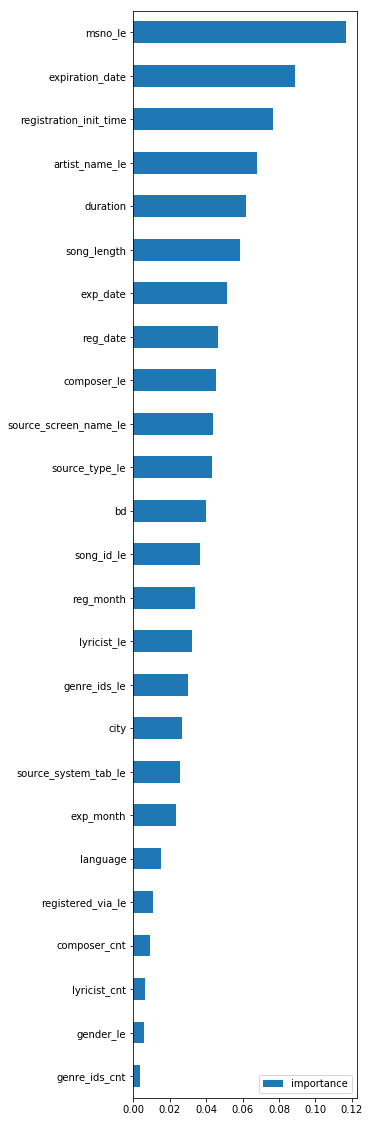

In [31]:
model = xgb.train(best_xgb_params, 
                  xgtrain, 
                  num_boost_round=200)

model.feature_names = full_vars
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance/ feature_importance.importance.sum()
feature_importance.sort_values(by='importance').head(30).plot(kind='barh',figsize=(4,20))
feature_importance.sort_values(by='importance',ascending=False).head(30)
plt.show()
test[target_var] = model.predict(xgb.DMatrix(test[full_vars].values))
test[target_var] = np.expm1(test[target_var]).clip(lower=0.)

sub = test[['id','target']].copy()
sub['id'].astype(int)
sub.head()
sub[['id', 'target']].to_csv('output/submission.csv', index=False)

## 2. Using LightGBM

### training set & random parameters
* set up the train data set for the fisrt time train
* select some random paramters to see if the result is accept or not

In [83]:
train_x = train[full_vars].values
train_y = train[target_var].values
lgtrain = lgb.Dataset(train_x, train_y)

lgb_params = {
    'learning_rate': 0.3,
    'max_depth': 15,
    'num_leaves': 100, 
    'objective': 'binary',
    'metric': {'auc'},
    'feature_fraction': 0.9,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'max_bin': 100}

In [84]:
cv_result_lgb = lgb.cv(lgb_params, 
                       lgtrain, 
                       num_boost_round=10000, 
                       nfold=5, 
                       stratified=True, 
                       early_stopping_rounds=50, 
                       verbose_eval=100, 
                       show_stdv=True)

num_boost_rounds_lgb = len(cv_result_lgb['auc-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))

[100]	cv_agg's auc: 0.754404 + 4.58022e-05
[200]	cv_agg's auc: 0.767277 + 0.000826771
[300]	cv_agg's auc: 0.772215 + 0.000986282
[400]	cv_agg's auc: 0.774513 + 0.0014285
[500]	cv_agg's auc: 0.774777 + 0.00105228
num_boost_rounds_lgb=461


In [90]:
print max(cv_result_lgb['auc-mean'])
print min(cv_result_lgb['auc-mean'])

0.775038896844134
0.6688549475495322


### Feature importance
* re-use the plot code from https://www.kaggle.com/yohanb/yet-another-lightgbm-starter-8gb-ram IN[8] and do some changes in order to fit our model and gain better explanation

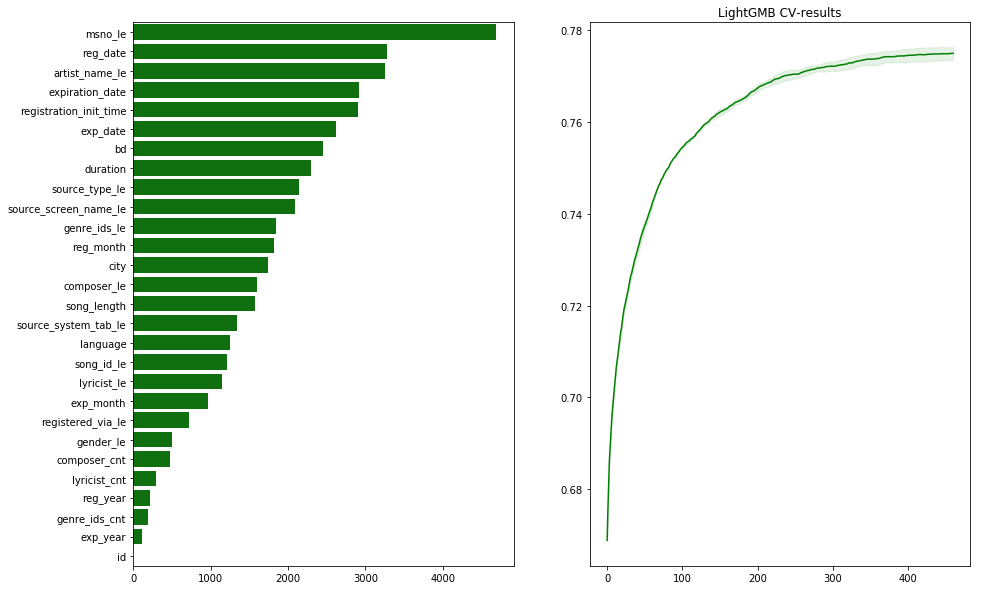

In [93]:
ROUNDS = num_boost_rounds_lgb
trained_1 = lgb.train(lgb_params, lgtrain, ROUNDS)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
feature_imp = pd.Series(dict(zip(full_vars, 
                                 trained_1.feature_importance()))).sort_values(ascending=False)
sns.barplot(x=feature_imp.values, y=feature_imp.index.values, orient='h', color='g')
plt.subplot(1,2,2)
train_scores = np.array(cv_result_lgb['auc-mean'])
train_stds = np.array(cv_result_lgb['auc-stdv'])
plt.plot(train_scores, color='green')
plt.fill_between(range(len(cv_result_lgb['auc-mean'])), 
                 train_scores - train_stds, train_scores + train_stds, 
                 alpha=0.1, color='green')
plt.title('LightGMB CV-results')
plt.show()



###  Create submission 

In [108]:
test_1 = pd.DataFrame()
test_1['target'] = trained_1.predict(test[full_vars].values)#_proba

In [111]:
test_1['target'] = np.expm1(test_1['target']).clip(0.0,1.0)

In [114]:
submission = pd.DataFrame()
submission['id'] = test['id'].astype(int).values
submission['target'] = test_1['target'].values
submission.to_csv('output/LGBM_1.csv.gz', compression = 'gzip', index=False, float_format = '%.5f') 

# Part-2 : Model tuning

### Manual tuning (greedy search)

* Tune one parameter at a time.
* Keep the best value for that parameter then move to find the next one.
* Repeat the process for all the parameters' range we want to tune.
* We reuse some code from url below and make some big changes to our project 
    https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823?scriptVersionId=1751960


#### Createa a parameter space

In [25]:
lgb_params = {}
lgb_params["objective"] = "binary"
lgb_params["learning_rate"] = 0.3
lgb_params["metric"] = {'auc'}
lgb_params["nthread"] = -1
lgb_params["seed"] = 1234

params_lgb_space = {}
params_lgb_space['max_bin'] = [127, 255, 511, 1023]
params_lgb_space['num_leaves'] = [15, 31, 63, 127, 255, 511, 1023]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_lgb_space['bagging_fraction'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_lgb_space['bagging_freq'] = [1, 3, 5]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]


greater_is_better = False
 

In [26]:
train_x = train[full_vars].values
train_y = train[target_var].values
lgtrain = lgb.Dataset(train_x, train_y)
best_lgb_params = lgb_params

In [28]:
for p in params_lgb_space:
    print ("Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('    %s: %s' % (p, v))#, end=""
        params[p] = v
               
        cv_results = lgb.cv(params, 
                             lgtrain,   
                             num_boost_round=1000, 
                             nfold=5, 
                             stratified=True, 
                             early_stopping_rounds=50, 
                             verbose_eval=100, 
                             show_stdv=True)
            
        best_iteration = len(cv_results)
        best_score = max(cv_results['auc-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('Best manually tuned parameters:', best_lgb_params)    



Tuning parameter num_leaves in [15, 31, 63, 127, 255, 511, 1023]
    num_leaves: 15
[100]	cv_agg's auc: 0.682853 + 0.000441949
[200]	cv_agg's auc: 0.69135 + 0.000468864
[300]	cv_agg's auc: 0.697183 + 0.000461538
[400]	cv_agg's auc: 0.701608 + 0.000457417
[500]	cv_agg's auc: 0.705371 + 0.000437271
[600]	cv_agg's auc: 0.708685 + 0.000553889
[700]	cv_agg's auc: 0.711649 + 0.000510154
[800]	cv_agg's auc: 0.714043 + 0.000413338
[900]	cv_agg's auc: 0.716669 + 0.00056912
[1000]	cv_agg's auc: 0.71905 + 0.000529813
, best_score: 0.719050, best_iteration: 2
    num_leaves: 31
[100]	cv_agg's auc: 0.693216 + 0.000357741
[200]	cv_agg's auc: 0.704986 + 0.00043673
[300]	cv_agg's auc: 0.712824 + 0.000610874
[400]	cv_agg's auc: 0.718916 + 0.000726841
[500]	cv_agg's auc: 0.723868 + 0.000711251
[600]	cv_agg's auc: 0.728172 + 0.000903413
[700]	cv_agg's auc: 0.731934 + 0.000922941
[800]	cv_agg's auc: 0.735256 + 0.000969848
[900]	cv_agg's auc: 0.738234 + 0.000643764
[1000]	cv_agg's auc: 0.741044 + 0.0007631

[200]	cv_agg's auc: 0.691316 + 0.000526105
[300]	cv_agg's auc: 0.69711 + 0.000597697
[400]	cv_agg's auc: 0.701822 + 0.000512876
[500]	cv_agg's auc: 0.705384 + 0.000517593
[600]	cv_agg's auc: 0.708543 + 0.000692781
[700]	cv_agg's auc: 0.711547 + 0.000605009
[800]	cv_agg's auc: 0.714333 + 0.000700996
[900]	cv_agg's auc: 0.716678 + 0.000612323
[1000]	cv_agg's auc: 0.719121 + 0.000810708
, best_score: 0.719121, best_iteration: 2
    lambda_l1: 1
[100]	cv_agg's auc: 0.682805 + 0.000435576
[200]	cv_agg's auc: 0.691278 + 0.000456328
[300]	cv_agg's auc: 0.697207 + 0.000556208
[400]	cv_agg's auc: 0.701498 + 0.000370352
[500]	cv_agg's auc: 0.705437 + 0.000368565
[600]	cv_agg's auc: 0.708647 + 0.000323059
[700]	cv_agg's auc: 0.711569 + 0.000507786
[800]	cv_agg's auc: 0.714405 + 0.000556693
[900]	cv_agg's auc: 0.716837 + 0.000538836
[1000]	cv_agg's auc: 0.719058 + 0.000404961
, best_score: 0.719058, best_iteration: 2
    lambda_l1: 10
[100]	cv_agg's auc: 0.682939 + 0.000425206
[200]	cv_agg's auc: 

[400]	cv_agg's auc: 0.70073 + 0.000649503
[500]	cv_agg's auc: 0.704297 + 0.000529471
[600]	cv_agg's auc: 0.70774 + 0.000525807
[700]	cv_agg's auc: 0.710589 + 0.000506763
[800]	cv_agg's auc: 0.713268 + 0.000445288
[900]	cv_agg's auc: 0.71582 + 0.00036948
[1000]	cv_agg's auc: 0.717967 + 0.000472094
, best_score: 0.717967, best_iteration: 2
    min_sum_hessian_in_leaf: 30
[100]	cv_agg's auc: 0.68257 + 0.0005394
[200]	cv_agg's auc: 0.69076 + 0.000480946
[300]	cv_agg's auc: 0.696506 + 0.000569591
[400]	cv_agg's auc: 0.700661 + 0.000579868
[500]	cv_agg's auc: 0.704269 + 0.00066709
[600]	cv_agg's auc: 0.707572 + 0.000451539
[700]	cv_agg's auc: 0.710519 + 0.00048622
[800]	cv_agg's auc: 0.713263 + 0.000562761
[900]	cv_agg's auc: 0.715712 + 0.000615008
[1000]	cv_agg's auc: 0.717716 + 0.000580497
, best_score: 0.717716, best_iteration: 2
    min_sum_hessian_in_leaf: 100
[100]	cv_agg's auc: 0.68257 + 0.0005394
[200]	cv_agg's auc: 0.690704 + 0.000478237
[300]	cv_agg's auc: 0.696586 + 0.000499056
[4

[200]	cv_agg's auc: 0.681577 + 0.000628888
[300]	cv_agg's auc: 0.683303 + 0.000527459
[400]	cv_agg's auc: 0.684296 + 0.000551667
[500]	cv_agg's auc: 0.684826 + 0.000598421
[600]	cv_agg's auc: 0.685333 + 0.000654795
[700]	cv_agg's auc: 0.685628 + 0.000752139
[800]	cv_agg's auc: 0.685759 + 0.000856769
[900]	cv_agg's auc: 0.685867 + 0.000923763
[1000]	cv_agg's auc: 0.685905 + 0.000938047
, best_score: 0.685905, best_iteration: 2
    feature_fraction: 0.3
[100]	cv_agg's auc: 0.678727 + 0.000563499
[200]	cv_agg's auc: 0.683138 + 0.000545891
[300]	cv_agg's auc: 0.685117 + 0.00037291
[400]	cv_agg's auc: 0.686165 + 0.000349853
[500]	cv_agg's auc: 0.686542 + 0.000438701
, best_score: 0.686606, best_iteration: 2
    feature_fraction: 0.4
[100]	cv_agg's auc: 0.679246 + 0.000594484
[200]	cv_agg's auc: 0.684121 + 0.000681113
[300]	cv_agg's auc: 0.686019 + 0.000589517
[400]	cv_agg's auc: 0.687152 + 0.000644682
[500]	cv_agg's auc: 0.687876 + 0.000648688
[600]	cv_agg's auc: 0.68804 + 0.000735848
, bes

'Best manually tuned parameters:', {'num_leaves': 15, 'verbose': 1, 'min_gain_to_split': 3, 'lambda_l1': 100, 'bagging_freq': 5, 'learning_rate': 0.1, 'lambda_l2': 100, 'nthread': -1, 'seed': 1234, 'max_bin': 127, 'objective': 'binary', 'bagging_fraction': 0.1, 'metric': set(['auc']), 'min_sum_hessian_in_leaf': 100, 'feature_fraction': 0.1}

### Automated tuning
* Base on the range, we get from manual tuning we could have a roughly range of parameters 
* We could doing automated tuning, which will give us more accurate predict result.
* We involved BayesianOptimization to finish this job.
* We re-use some code from url below and make some changes to original code in order to fit our situation.: https://zhuanlan.zhihu.com/p/27916208

In [33]:
def lgb_evaluate(max_bin,
                 num_leaves,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2
                 ):
    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.3
    params['max_bin'] = int(max_bin)
    params['num_leaves'] = int(num_leaves)    
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = int(bagging_freq)
    params["metric"] = {'auc'}
    params["nthread"] = -1    


    cv_results = lgb.cv(params, 
                             lgtrain,   
                             num_boost_round=1000, 
                             nfold=5, 
                             stratified=True, 
                             early_stopping_rounds=50, 
                             verbose_eval=100, 
                             show_stdv=True)
            
    best_iteration = len(cv_results)
    best_score = max(cv_results['auc-mean'])
    
    
    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return best_score


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {'max_bin': (125, 129),
                              'num_leaves': (12, 17),
                              'min_sum_hessian_in_leaf': (97, 103),
                              'min_gain_to_split': (1,5),
                              'feature_fraction': (0.1, 0.4),
                              'bagging_fraction': (0.1,0.4),
                              'bagging_freq': (3,7),
                              'lambda_l1': (97,103),
                              'lambda_l2': (97,103)
                             }
                            )

lgb_BO.maximize(init_points=3, n_iter=10)


Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
[100]	cv_agg's auc: 0.681435 + 0.00053865
[200]	cv_agg's auc: 0.688186 + 0.000460747
[300]	cv_agg's auc: 0.693063 + 0.0004455
[400]	cv_agg's auc: 0.696765 + 0.000384321
[500]	cv_agg's auc: 0.699905 + 0.000370833
[600]	cv_agg's auc: 0.702529 + 0.000487188
[700]	cv_agg's auc: 0.704775 + 0.000465904
[800]	cv_agg's auc: 0.706827 + 0.000452677
[900]	cv_agg's auc: 0.708585 + 0.000543043
[1000]	cv_agg's auc: 0.710097 + 0.000537625
, best_score: 0.710097, best_iteration: 2
    1 | 32m02s |    0.71010 |             0.1154 |         6.1333 |             0.2874 |     98.8203 |    102.6384 |  127.4499

/Users/xinyuewang/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.26593262e-05]), 'nit': 5, 'funcalls': 54}
  " state: %s" % convergence_dict)


[100]	cv_agg's auc: 0.680287 + 0.00050767
[200]	cv_agg's auc: 0.687487 + 0.000496107
[300]	cv_agg's auc: 0.692087 + 0.000455829
[400]	cv_agg's auc: 0.695598 + 0.000482765
[500]	cv_agg's auc: 0.698605 + 0.000448676
[600]	cv_agg's auc: 0.701229 + 0.000543969
[700]	cv_agg's auc: 0.703454 + 0.000524405
[800]	cv_agg's auc: 0.705504 + 0.000471609
[900]	cv_agg's auc: 0.707174 + 0.000482933
[1000]	cv_agg's auc: 0.708833 + 0.000526351
, best_score: 0.708833, best_iteration: 2
   10 | 31m11s |    0.70883 |             0.1030 |         3.0321 |             0.3277 |    102.8983 |     97.6280 |  128.9754 |              1.3456 |                   97.2903 |      13.5185 | 
[100]	cv_agg's auc: 0.682302 + 0.000465227
[200]	cv_agg's auc: 0.689291 + 0.000495955
[300]	cv_agg's auc: 0.694203 + 0.000569835
[400]	cv_agg's auc: 0.697907 + 0.000418178
[500]	cv_agg's auc: 0.701008 + 0.00046277
[600]	cv_agg's auc: 0.70356 + 0.000488499
[700]	cv_agg's auc: 0.705846 + 0.000595201
[800]	cv_agg's auc: 0.707736 + 0.0

#### Show LightGBM tuning results

In [34]:
lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores.head(10)

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,max_bin,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
0,0.277844,3.452264,0.291070,97.581224,97.060256,128.024200,1.097551,97.407070,16.907623,0.715239
4,0.226085,3.059503,0.377474,99.011642,98.624034,125.014336,1.068833,102.672966,15.281577,0.714815
7,0.129242,3.211599,0.246571,97.338343,97.659840,128.511115,1.358958,102.882183,16.710547,0.711173
2,0.389890,4.261170,0.399169,97.173144,97.107652,128.800138,1.202374,102.924437,12.638526,0.710613
8,0.320280,3.346834,0.362022,97.128336,102.609982,127.535729,2.081079,97.040483,12.653164,0.709753
6,0.103032,3.032095,0.327712,102.898332,97.627997,128.975436,1.345620,97.290291,13.518461,0.708833
5,0.385701,6.980892,0.116806,102.271746,97.269683,126.242207,1.008844,100.277089,16.996984,0.704591
9,0.100000,3.394685,0.400000,97.000000,103.000000,125.000000,5.000000,97.000000,16.942451,0.704428
3,0.211508,6.991398,0.224314,97.068244,98.671368,125.352312,4.959310,102.531448,16.432121,0.703664
1,0.375770,3.310887,0.117934,103.000000,102.895305,129.000000,4.967499,102.999721,17.000000,0.699071


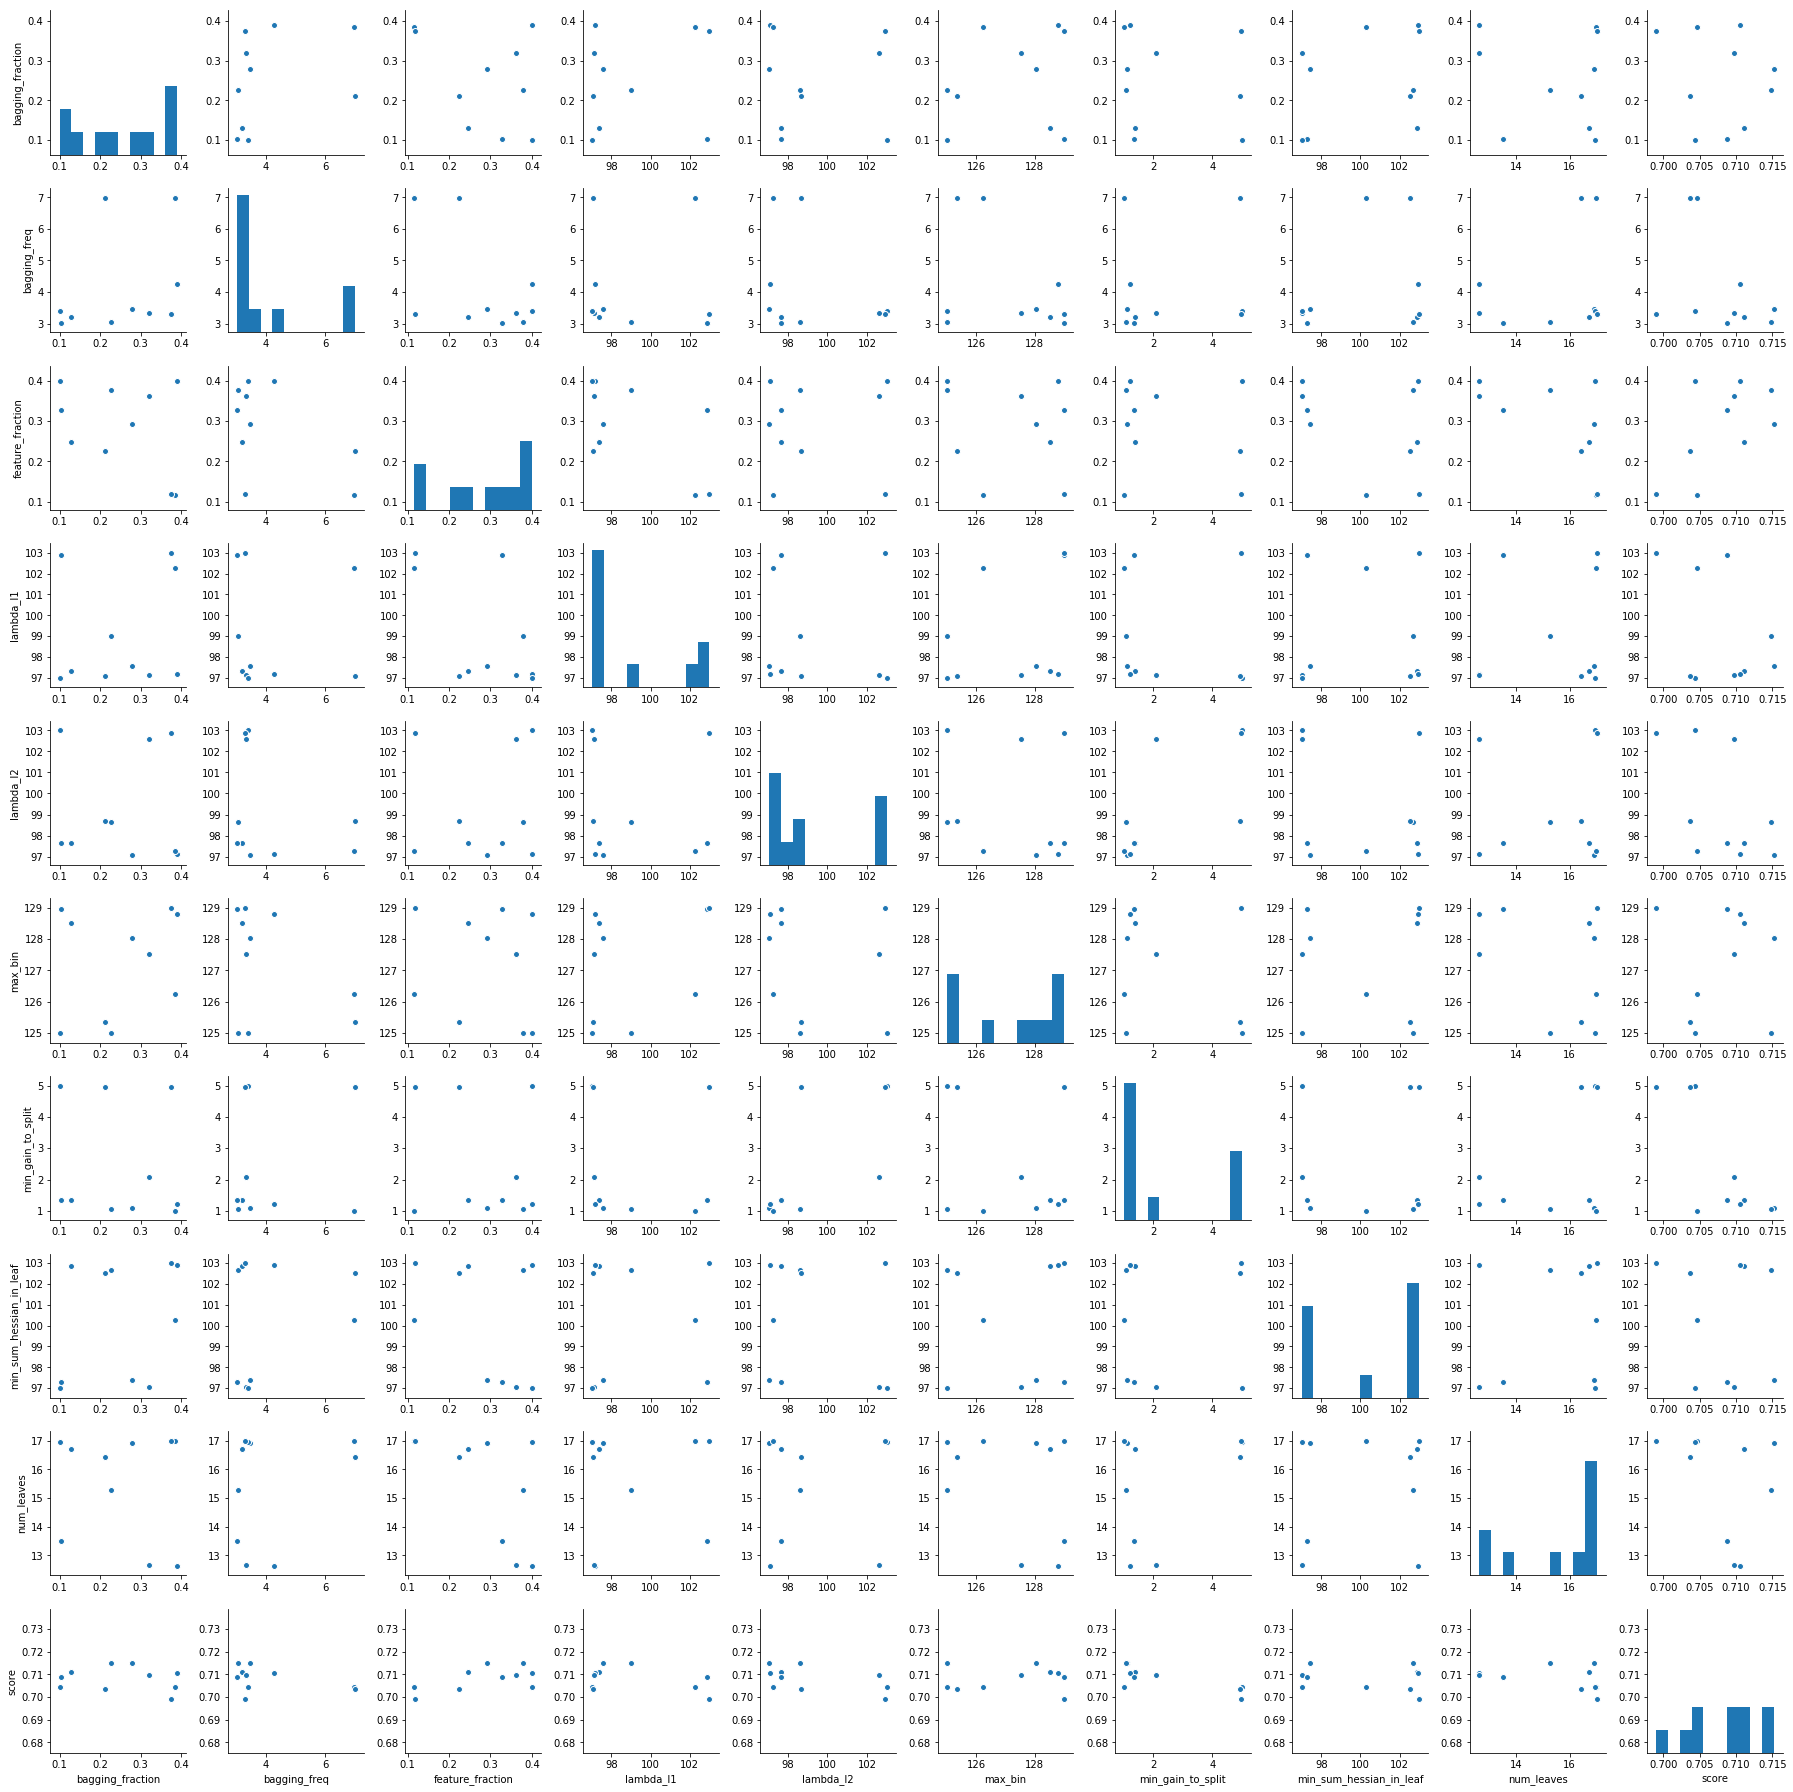

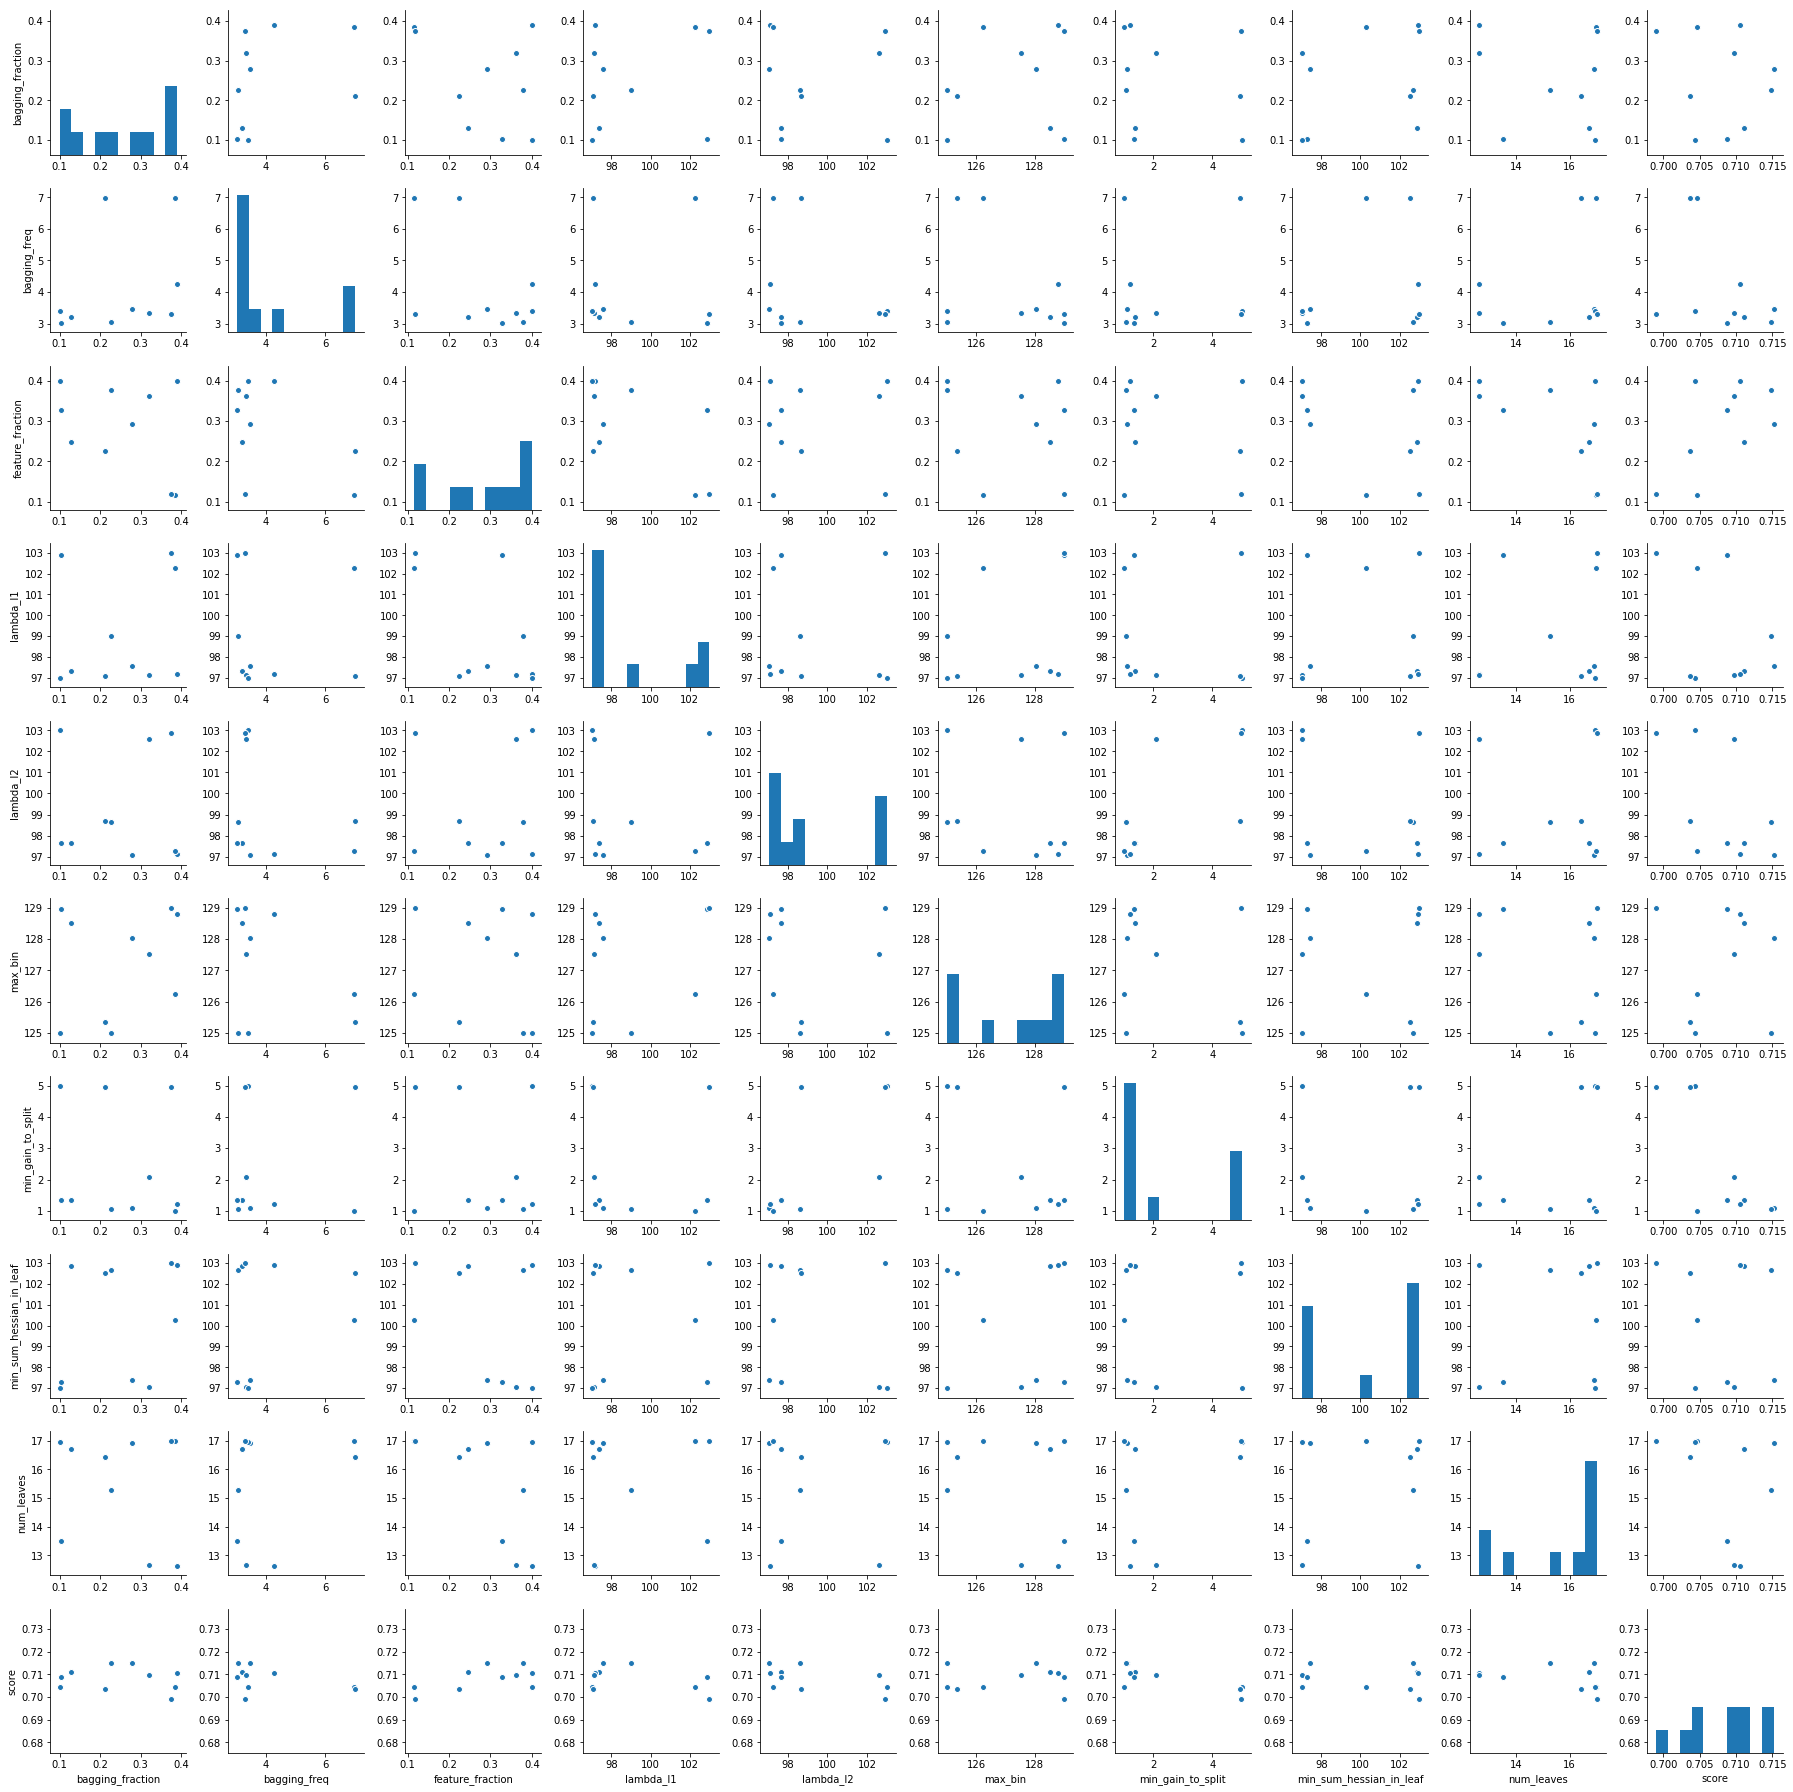

In [36]:
sns.pairplot(lgb_BO_scores)
plt.show()

# Part-3 : Final Submit

* Base on the tuning precess, we choose best parameters and put them into final LGBM model  
* Using whole data set and train the new model
* Submit the final results

In [27]:
train_x = train[full_vars].values
train_y = train[target_var].values
lgtrain = lgb.Dataset(train_x, train_y)

In [37]:
lgb_params = {
    'learning_rate': 0.3,
    'max_depth': 10,
    'num_leaves': 17,
    'bagging_freq' :3.5
    'objective': 'binary',
    'metric': {'auc'},
    'feature_fraction': 0.3,
    'bagging_fraction': 0.3,
    'bagging_freq': 3,
    'max_bin': 128,
    'min_gain_to_split':1,
    'lambda_l2':97,
    'lambda_l1' :97}

In [38]:
ROUNDS = 1000
trained_1 = lgb.train(lgb_params, lgtrain, ROUNDS)

###  Create submission 

In [39]:
test_1 = pd.DataFrame()
test_1['target'] = trained_1.predict(test[full_vars].values)#_proba
#test_1['target'] = trained_1.predict_proba(test[full_vars].values)
test_1['target'] = np.expm1(test_1['target']).clip(0.0,1.0)
submission = pd.DataFrame()
submission['id'] = test['id'].astype(int).values
submission['target'] = test_1['target'].values
submission.to_csv('output/LGBM_pro_final_2.csv.gz', compression = 'gzip', index=False, float_format = '%.5f') 

# Submit Result

![aaaa](r1.jpg)